# DT8122 - Assignment

<span style="color:red">Deadline: 2023 August 15 AoE (Anywhere on Earth)</span>

Send a zip file with the notebook both as a .ipynb and as a .pdf file to <a href="mailto:dt8122@idi.ntnu.no">dt8122@idi.ntnu.no</a>. Label the file with your full name.

The task is to implement conditional DDPM for MNIST images. Your implementation should take as input a digit and be able to generate 28x28 grayscale handwritten image of said digit. 

You can add additional cells anywhere in the notebook to make your code more readable.

DDPM: https://arxiv.org/abs/2006.11239

Classifier-free conditional DDPM: https://arxiv.org/abs/2207.12598

The notebook should be run when it is turned in so all plots are visible. All code should be contained in the notebook.


### Install necessary libraries
Any additional libraries you make use of should be installed in this cell.

### Import libraries
All import statements should be contained here.

In [2]:
import random
import math

import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

### Define constants here
Constants such as number of epochs, device, and learning rate and other hyperparameters should be defined here.

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 64

### Functionality for loading and visualizing dataset
We have provided some functionality for loading and visualizing the dataset. You may add more cells/functions here.

In [4]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [30]:
dataset = DDPMDataset(dataset)
print(len(dataset))
print(dataset[0][1:])

60000
(5, tensor([8]))


In [5]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

shape of x: torch.Size([64, 1, 28, 28])


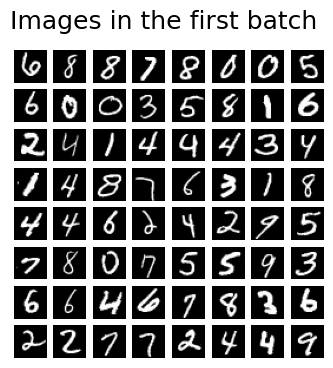

In [6]:
def show_first_batch(loader):
    for batch in loader:
        print("shape of x:", batch[0].shape)
        show_images(batch[0], "Images in the first batch")
        break
show_first_batch(loader)

### Your conditional DDPM implementation should go here
This includes functionality for adding noise to the image.

#### Forward diffusion

This includes the calculations of alpha-bars, and the forward diffusion-process

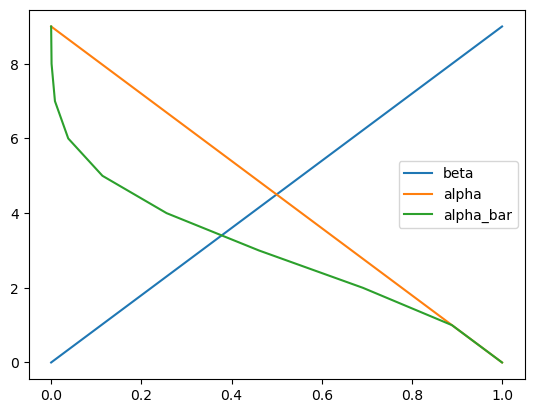

tensor([0.4609, 0.0000, 0.0084, 0.4609, 0.0084, 0.4609, 0.8889, 0.0379, 0.0379,
        0.0000])


In [7]:
def get_alpha_bars(beta_min, beta_max, num_diff_steps):
    betas = torch.linspace(beta_min, beta_max, num_diff_steps)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim = 0)
    #print(alphas.shape)
    #print(alpha_bars.shape)
    return betas, alphas, alpha_bars

# visualize the results over the diff_steps
beta_min = 0.0
beta_max = 1.0
num_diff_steps = 10
betas, alphas, alpha_bars_test = get_alpha_bars(beta_min, beta_max, num_diff_steps)
plt.plot(betas, torch.arange(num_diff_steps), label="beta")
plt.plot(alphas, torch.arange(num_diff_steps), label="alpha")
plt.plot(alpha_bars_test, torch.arange(num_diff_steps), label="alpha_bar")
plt.legend()
plt.show()

# Find alpha_bars for a random batch of ts
ts = torch.randint_like(torch.arange(10), 0, num_diff_steps)
alpha_bars_test = alpha_bars_test[ts]
print(alpha_bars_test)

torch.Size([2, 1, 28, 28])


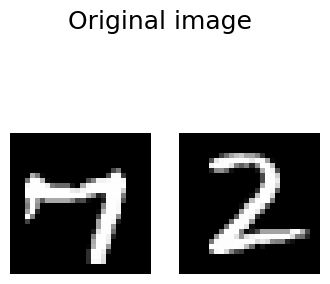

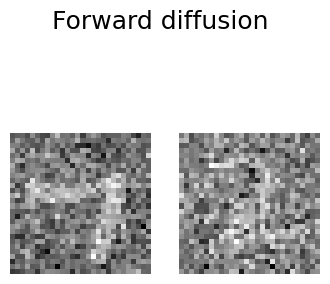

In [12]:
def forward_diffusion(x_0, noise, alpha_bars):
    """
    Applies the forward diffusion process to a batch of images.

    The forward diffusion process involves scaling the images by the square root of 
    alpha_bars, then generating new images by sampling from a Gaussian distribution 
    with means given by the scaled images and standard deviations given by the 
    square root of (1 - alpha_bars).

    Args:
        x_0 (torch.Tensor): A tensor representing a batch of images. The tensor's 
            shape should be (batch_size, num_channels, height, width).
        alpha_bars (torch.Tensor): A tensor containing the scaling factors for each 
            image in the batch. The tensor's shape should be (batch_size,).
        noise (torch.Tensor): A tensor containing the noise to be added to the
            images. The tensor's shape should be (batch_size, num_channels, height,
            width).

    Returns:
        torch.Tensor: A tensor representing a batch of generated images. The tensor's 
            shape will be the same as the shape of x_0.

    Raises:
        AssertionError: If the batch size of x_0 and alpha_bars do not match.
    """
    # Assert that the number of images and number of alpha_bars match, 
    # if not, raise an AssertionError and print the shape of x_0 and alpha_bars
    assert x_0.shape[0] == alpha_bars.shape[0], f"Shape of x_0: {x_0.shape}, shape of alpha_bars: {alpha_bars.shape}"
    
    alpha_bars = alpha_bars.view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bars) * x_0 + torch.sqrt(1 - alpha_bars) * noise
    return x_t


# Test forward_diffusion for an image
x_0 = next(iter(loader))[0][0:2]
print(x_0.shape)
show_images(x_0, "Original image")

alpha_bar = torch.tensor([0.5, 0.2])
x_t = forward_diffusion(x_0, alpha_bar)
show_images(x_t, "Forward diffusion")

### The implementation of the neural network used to estimate the noise should go here
The network should make use of both time and context embedding.

Any functions/methods used for time and context embeddings should also go here.

#### Temporal encoding


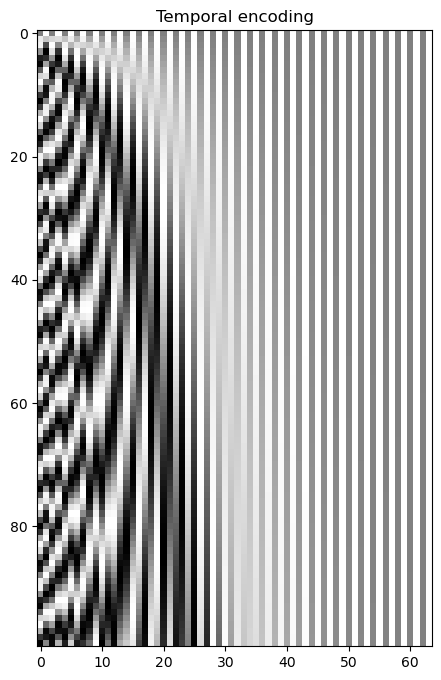

In [8]:
def temporal_encoding(d_emb, num_ts):
    """
    Returns the temporal sinusoidal encoding for all 
    timesteps up to num_ts, with d_emb dimensions.

    This only needs to be computed once, and get_temporal_encoding
    can be used to retrieve the encoding for a particular timestep.
    
    Args:
        d_emb (int): The number of dimensions in the embedding.
        num_ts (int): The number of timesteps to encode.
    Returns:
        torch.Tensor (d_emb, num_ts): A tensor representing the sinusoidal encoding for all timesteps.

    """

    positions = torch.arange(num_ts).unsqueeze(1)
    div_term = torch.exp(-torch.arange(0,d_emb, 2) * math.log(10000.0)/d_emb)
    pe = torch.zeros(num_ts, d_emb)
    #print(positions.shape, "positions")
    #print(div_term.shape, "div_term")
    #print((positions * div_term).shape, "positions * div_term")
    pe[:, ::2] = torch.sin(positions * div_term)
    pe[:, 1::2] = torch.cos(positions * div_term)
    return pe


def get_temporal_encoding(t, d_emb, num_ts):
    """
    Returns the temporal encoding for timestep t, 
    with d_emb dimensions.

    Args:
        t (int): The timestep to get the encoding for.
        d_emb (int): The number of dimensions in the embedding.
        num_ts (int): The number of timesteps to encode.
    Returns:
        torch.Tensor (d_emb,): A tensor representing the sinusoidal encoding for timestep t.

    """
    pe = temporal_encoding(d_emb, num_ts)
    return pe[t]

#  visualize temporal encoding
d_emb = 64
temp_enc = temporal_encoding(d_emb, 100)
plt.figure(figsize=(8, 8))
plt.imshow(temp_enc, cmap="gray")
plt.title("Temporal encoding")

plt.show()

#### Model definition

In [9]:
import lightning.pytorch as pl

class NoisePredictor(pl.LightningModule):
    """
    Predicts the noise level for a batch of images.

    Args:
        input (torch.Tensor): A tensor representing a batch of noisy images.
        (batch_size, num_channels, height, width)

    Returns:
        torch.Tensor: A tensor representing the predicted noise level for each image 
            in the batch.(batch_size, num_channels, height, width)
    """
    def __init__(self, num_timesteps, d_emb):
        super(NoisePredictor, self).__init__()
        self.fc1 = nn.Linear(28*28 + d_emb, 128)
        self.fc2 = nn.Linear(128, 128) 
        self.fc3 = nn.Linear(128, 28*28)
        self.temp_enc = nn.Embedding(num_timesteps, d_emb)
        self.temp_enc.weight.data = temporal_encoding(d_emb, num_timesteps) 
        self.temp_enc.weight.requires_grad = False


    def forward(self, x, t):
        x = x.view(-1, 28*28)
        x = torch.cat((x, self.temp_enc(t)), dim=1) # (batch_size, 28*28 + d_emb)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x).view(-1, 1, 28, 28)
    
    def get_temp_enc(self, t):
        return self.temp_enc(t)
    
    def training_step(self, batch):
        noisy_imgs, t, true_noise = batch
        y = self.forward(noisy_imgs, t)
        loss = F.mse_loss(y, true_noise)
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self, lr=1e-3):
        return torch.optim.Adam(self.parameters(), lr=lr)


In [29]:
from torch.utils.data import Dataset

class DDPMDataset(Dataset):
    def __init__(self, dataset, num_diff_steps=100):
        self.mnist = MNIST("./datasets", download=True, train=True, transform=transform)
        self.betas, self.alphas, self.alphas_bars = get_betas_alphas(num_diff_steps)
    def __getitem__(self, index):
        # Want to
        # 1. get image from dataset
        # 2. sample noise for image
        # 3. sample diffusion step
        # 4. return image+noise, noise, diffusion step
        img, label = self.mnist[index]
        noise = torch.randn_like(img) # sample noise for image
        t = torch.randint(0, num_diff_steps, (1,) ,dtype=torch.long)
        alpha_bars_t = self.alphas_bars[t]
        noisy_image = forward_diffusion(img, t, noise)

        return img, label, t

    def __len__(self):
        return len(self.mnist)


Text(0.5, 1.0, 'Temporal encoding')

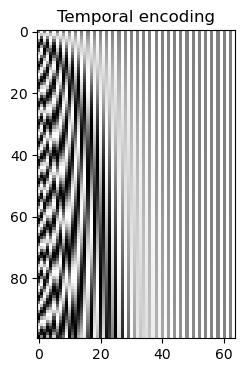

In [10]:
model = NoisePredictor(num_timesteps=100, d_emb=64)
# Small test to check the temporal encoding of the noise predictor
temp_enc = model.get_temp_enc(torch.linspace(0, 99, 100, dtype=torch.long))
plt.figure(figsize=(4, 4))  
plt.imshow(temp_enc, cmap="gray")
plt.title("Temporal encoding")

### Show that you can generate images before the model is trained
This should demonstrate that the backwards pass works. The generated images are expected to be noise.

torch.Size([2, 1, 28, 28])


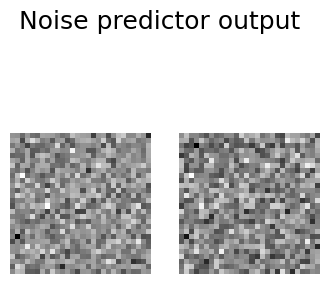

In [13]:
output = model(x_0, t=torch.randint(0, 100, (2,)))
print(output.shape)
## Visualize the output of the noise predictor
show_images(output, "Noise predictor output")

### Implement training loop
Train the model here. There should be some indication of how long the model took to train, both total and per epoch. For good results you will want to train the model for several epochs, but with a good implementation you should expect to see something that looks like digits after only a single epoch.

In [ ]:
trainer = pl.Trainer(limit_train_batches=10, max_epochs=10)
trainer.fit(model, loader)

In [ ]:
# Hyperparameters
beta_min = 1e-4
beta_max = 1e-2
num_diff_steps = 100
batch_size = 64
lr = 1e-3
num_epochs = 100


loss = torch.nn.MSELoss()

betas, alphas, alpha_bars = get_alpha_bars(beta_min, beta_max, num_diff_steps)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    for batch in loader:
        x, y = batch
        # sample ts as torch.long from a uniform distribution
        ts = torch.randint(0, num_diff_steps, (x.shape[0],), dtype=torch.long)
        #print("ts shape", ts.shape)
        #print("alpha_bars shape", alpha_bars.shape)
        alpha_bars_ts = alpha_bars[ts]
        #print("alpha_bars_ts shape", alpha_bars_ts.shape)
        #print(batch[0].shape)
        eps = torch.randn_like(x)
        # Training step
        training_batch = (forward_diffusion(x, alpha_bars_ts), ts, true_noise)
        
        #preds = model(forward_diffusion(x, alpha_bars_ts), ts)
        #loss(preds, eps).backward()

        optimizer.step()
        optimizer.zero_grad()

### Train and visualize the model
We want to see several generated examples of each digit.

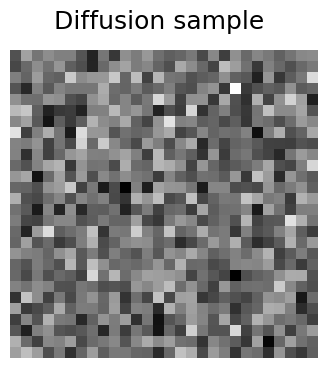

In [ ]:
x = torch.randn(1, 1, 28, 28)
with torch.no_grad():
    for t in range(num_diff_steps, 0):
        noise_pred = model(x,t)
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        beta_t = betas[t]
        x = 1/torch.sqrt(alpha_t) * (x - ((1-alpha_t)/torch.sqrt(1 - alpha_bar_t)) * noise_pred) + torch.sqrt(beta_t) * pure_noise

        if t > 0:
            pure_noise = torch.randn(1, 1, 28, 28)
            x  = x + torch.sqrt(beta_t) * pure_noise

show_images(x, "Diffusion sample")